In [61]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCS = 50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory('PlantVillage',
                            shuffle = True,
                            image_size = (IMAGE_SIZE,IMAGE_SIZE),
                            batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


2022-10-09 09:53:15.684226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[5].shape)

(32, 256, 256, 3)
[0 1 1 0 1 2 1 0 2 2 1 1 1 1 1 0 1 0 1 2 1 1 0 0 1 1 1 0 2 2 1 0]
(256, 256, 3)


This shows that we have 3 channels called RGB and following classification class where 0/1/2 helps us to classifiy the images into their respective class

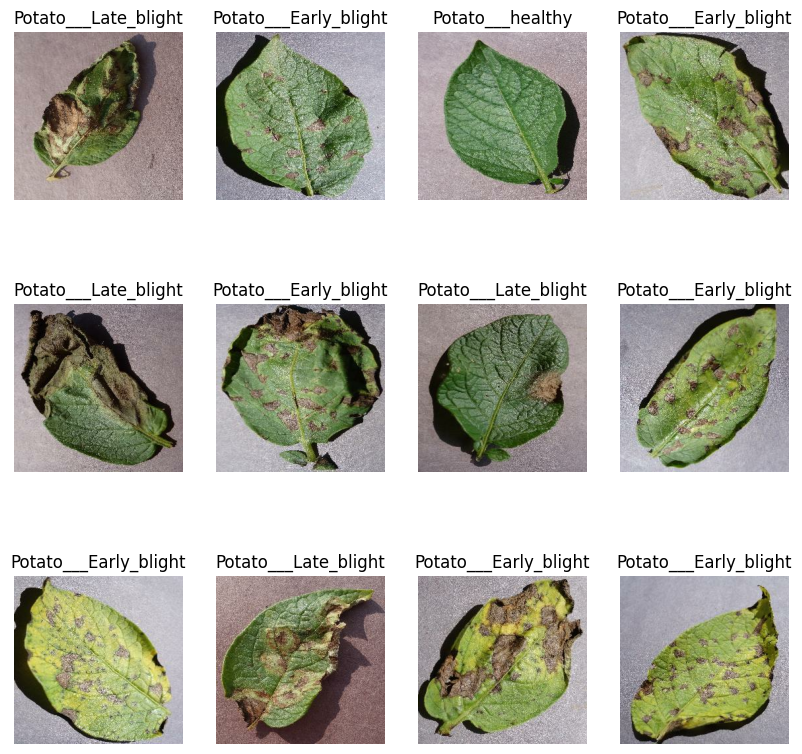

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
len(dataset)

68

The data will now be split into 80% training and 20% testing of which the 10% will be used for the validation set.
80% ==> Training
20% ==> 10% validation, 10% test

In [9]:
#In sklearn we have train test split dataset but we don't have that in tensorfow. For that we will have to do
#dataset.take() which will take the first 10 set of data set for training dataset.take(10)
#Setting up the training testset
train_size = 0.8
len(dataset)*train_size

54.400000000000006

We will take the first 54 dataset as the train dataset to train our samples

In [10]:
train_ds = dataset.take(54) #dataset[:54] "Pandas comparisor"
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54) #dataset[54:] "Pandas comparison"
len(test_ds)

14

Since The validation data set is 10% of the test dataset we need to take the 10% of the tests dataset and split it into a validation the data set which will be 10%.

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

Now that we have taken the six data set from our test data set for the validation data set we need to skip the six on the test data set so that our test data set invalidation data sets or separate.

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

We can also wrap all of these functions into a single python function.

In [19]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split=0.1,test_split=0.1,shuffle= True,shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds , val_ds , test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

Cashing allows us to keep the data into the memory so that when we are doing different iterations of the Model, How resulting training would be faster.

https://www.youtube.com/watch?v=MLEKEplgCas&ab_channel=codebasics

In [24]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

This helps to resize the image into 256 x 256 size as the input data in our production phase may be in a different size. This helps to Get the predicted image into the 256 x 2 56 format.

In [25]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

We also need to do a Data argumentation step in which we re-process the data that is being fed if it is in the rotated format or if the contrast of the data that is being fed into the model is not in the right training format. https://www.youtube.com/watch?v=mTVf7BN7S8w&ab_channel=codebasics

In [26]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Now we're ready to build a Convolution neural neural network which is great at image classification.

In [29]:
input_shape =(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3

In [33]:
model = models.Sequential([
    resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [37]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [38]:
history=model.fit(train_ds,
          epochs=EPOCS,
          batch_size=BATCH_SIZE,
          verbose =1,
          validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 45s 793ms/step - loss: 0.9181 - accuracy: 0.5053 - val_loss: 0.9581 - val_accuracy: 0.4740
Epoch 2/50
54/54 [==============================] - 43s 782ms/step - loss: 0.7800 - accuracy: 0.6297 - val_loss: 0.7402 - val_accuracy: 0.6964
Epoch 3/50
54/54 [==============================] - 44s 806ms/step - loss: 0.4860 - accuracy: 0.8038 - val_loss: 0.4268 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 45s 825ms/step - loss: 0.3204 - accuracy: 0.8703 - val_loss: 0.3475 - val_accuracy: 0.8646
Epoch 5/50
54/54 [==============================] - 48s 864ms/step - loss: 0.2449 - accuracy: 0.9073 - val_loss: 0.2360 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 48s 873ms/step - loss: 0.2456 - accuracy: 0.8985 - val_loss: 0.2162 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 46s 833ms/step - loss: 0.2393 - accuracy: 0.9061 - val_loss: 0.3070 - val_accuracy: 0.9115

In [39]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 238ms/step - loss: 0.2098 - accuracy: 0.9375


In [40]:
scores

[0.20980623364448547, 0.9375]

In [42]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

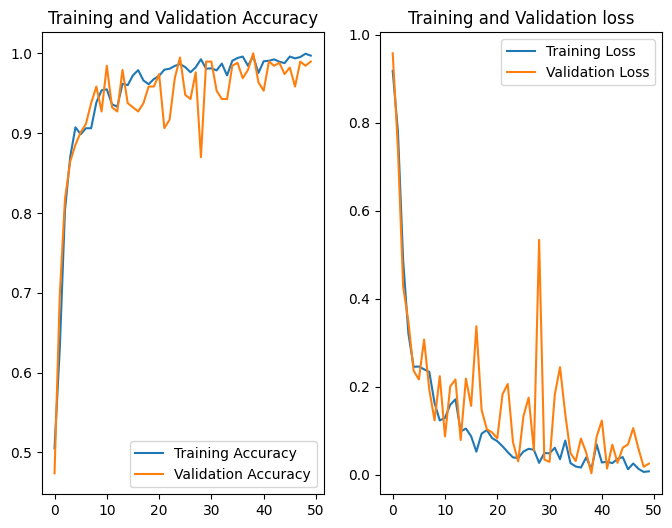

In [51]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCS),acc, label='Training Accuracy')
plt.plot(range(EPOCS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCS),loss, label='Training Loss')
plt.plot(range(EPOCS),val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')


First image to predict
First image's actual label: Potato___Late_blight
1/1 [==============================] - 0s 305ms/step
Predicted Label: Potato___Late_blight


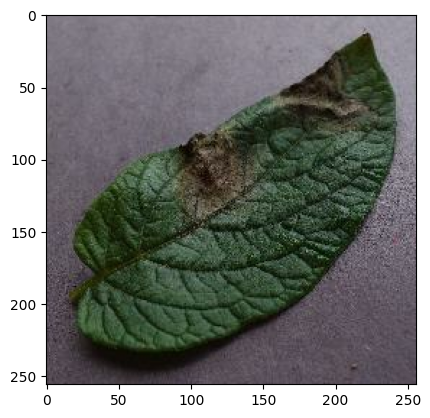

In [76]:
for image_batch, label_batch in test_ds.take(1):
    #plt.imshow(image_batch[0].numpy().astype('uint8'))
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print('First image to predict')
    plt.imshow(first_image)
    print("First image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print('Predicted Label:',class_names[np.argmax(batch_prediction[0])])

In [85]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class , confidence

1/1 [==============================] - 0s 24ms/step


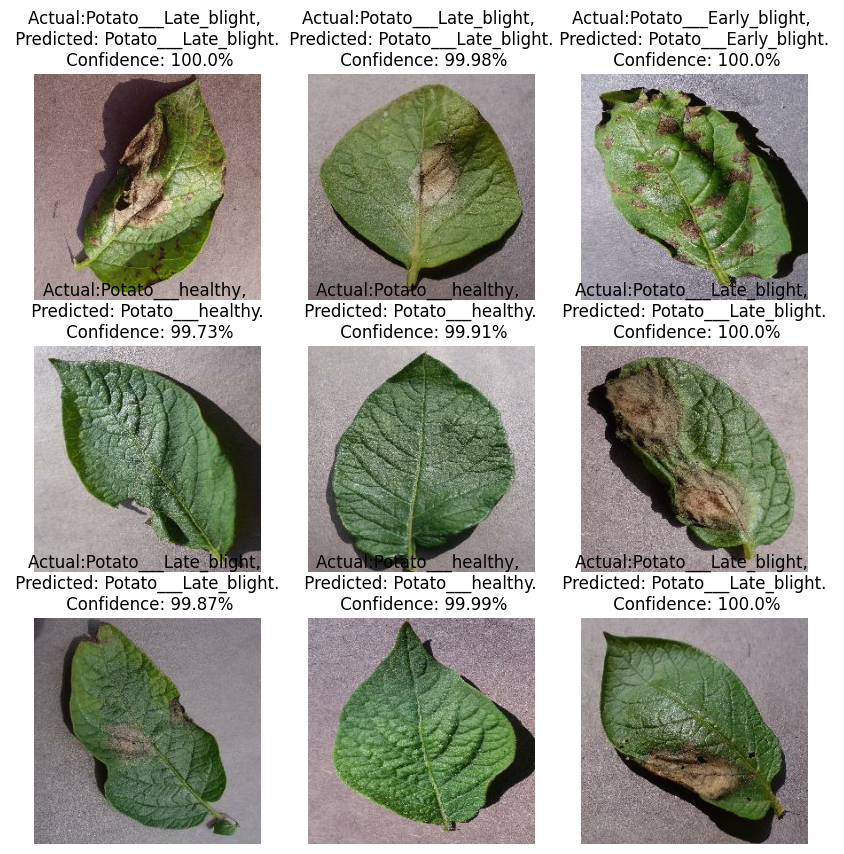

In [87]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class , confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual:{actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis('off')

In [93]:
import os
os.listdir('./Models')

['.DS_Store', '1']

In [89]:
model_version = 1
model.save(f'./Models/{model_version}')

INFO:tensorflow:Assets written to: ./Models/1/assets


INFO:tensorflow:Assets written to: ./Models/1/assets
